In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
df = pd.read_csv('Pasion et al dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [4]:
df_corr = df[['Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()

In [5]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))

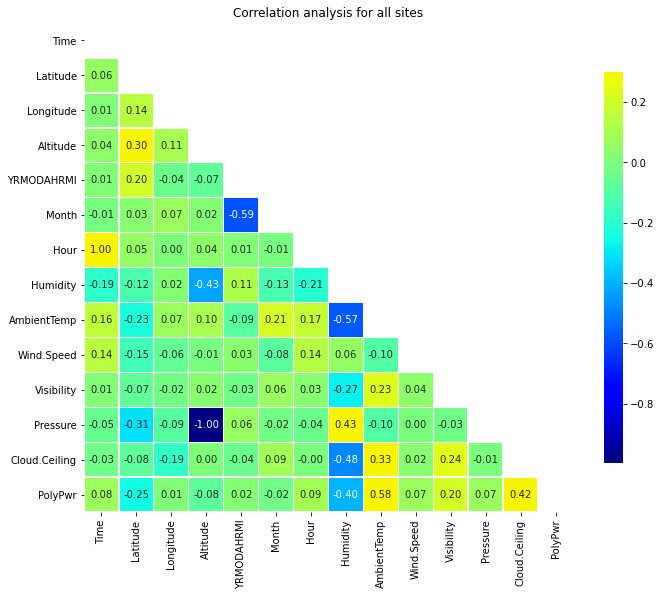

In [6]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_corr, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis for all sites');

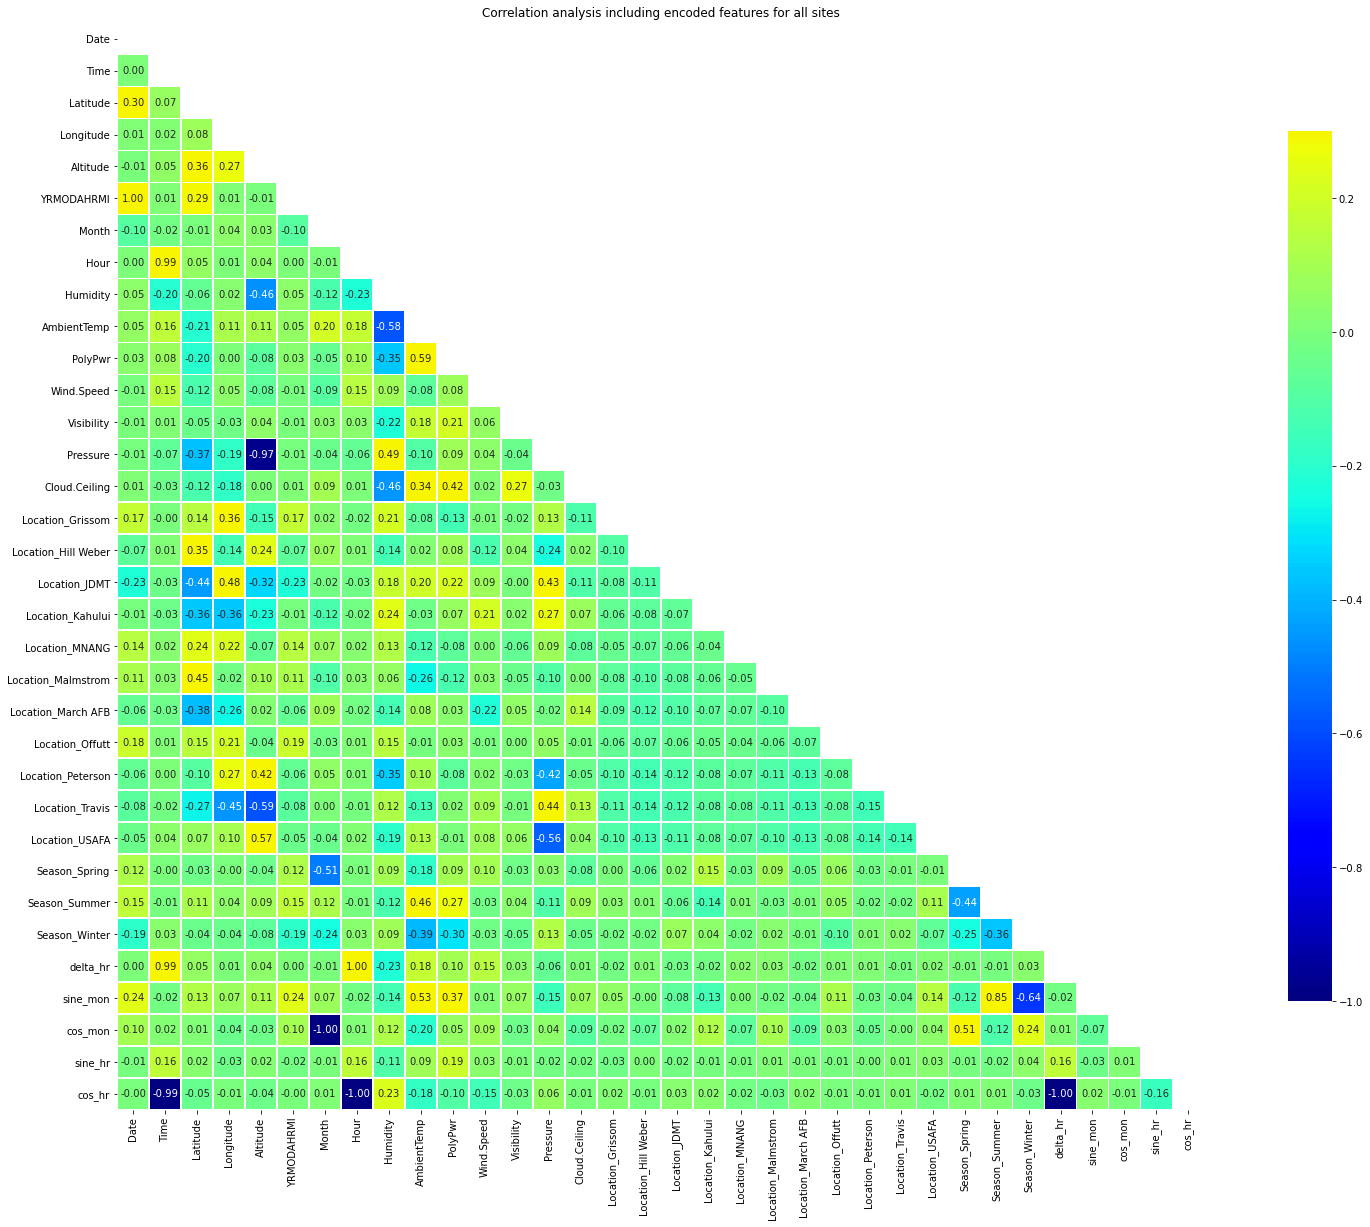

In [7]:
df_with_location_en = pd.get_dummies(df, columns=['Location'], drop_first=True)
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)
min_hour_of_interest = 10
max_hour_of_interest = 15
df_with_loc_season_en['delta_hr']= df_with_loc_season_en.Hour - min_hour_of_interest
df_with_loc_season_en['sine_mon']= np.sin((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['cos_mon']= np.cos((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['sine_hr']= np.sin((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr']= np.cos((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
mask2 = np.triu(np.ones_like(df_with_loc_season_en.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df_with_loc_season_en.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis including encoded features for all sites');

In [8]:
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']
df_processed = df_with_loc_season_en[selected_columns].reset_index(drop=True)
target_label = 'PolyPwr'
input_feat = list(set(selected_columns).difference(set([target_label])))

In [9]:
df_X = df_processed[input_feat].reset_index(drop=True)
df_y = df_processed[target_label]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [12]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Conv1D, ReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [13]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [14]:
def dl_model(n_units1, n_units2, n_units3, act1, act2, act3, ker_init, lr, dr0, dr1, dl_loss):
    model = Sequential()
    model.add(Dense(n_units1, activation=act1, kernel_initializer=ker_init, input_dim=X_train.shape[1]))
    # model.add(Dense(n_units1, activation=act1, kernel_initializer=ker_init))
    model.add(Dropout(dr0))
    model.add(Dense(n_units2, activation=act2, kernel_initializer=ker_init))
    model.add(Dropout(dr1))
    model.add(Dense(n_units3, activation=act3, kernel_initializer=ker_init))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=[r_squared, tf.keras.metrics.mean_squared_error], loss=dl_loss)
    return model

In [15]:
def custom_loss(y_true, y_pred):
    # (1-R2)
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return SS_res/(SS_tot+K.epsilon())

In [16]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))

In [17]:
# Create list of each hyper-param to tune
# n_units0_list = [40*x for x in range(3, 10)]
n_units1_list = [40*x for x in range(3, 10)]
n_units2_list = [40*x for x in range(3, 10)]
n_units3_list = [40*x for x in range(3, 10)]

# act0_list = ['relu', 'tanh']
act1_list = ['relu', 'tanh']
act2_list = ['relu', 'tanh']
act3_list = ['relu', 'tanh']

ker_init_list = ['glorot_normal', 'glorot_uniform']

learning_rate_list = [round(np.power(0.1, x/3), 5) for x in range(8, 11)]

dl_loss_list = [custom_loss, 'mean_squared_error']

# batch_size_list = [np.int64(150*x) for x in range(1, 6)]
batch_size_list = [600]

# epochs_list = [np.int64(30*x) for x in range(1, 4)]
epochs_list = [100]

dr0_list = [0.1, 0.2, 0.3]
dr1_list = [0.1, 0.2, 0.3]

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [18]:
# Structure model hyper-params as a dictionary
dl_grid = {'kr__n_units1':n_units1_list,
            'kr__n_units2':n_units2_list,
            'kr__n_units3':n_units3_list,
            'kr__act1':act1_list,
            'kr__act2':act2_list,
            'kr__act3':act3_list,
            'kr__ker_init':ker_init_list,
            'kr__lr':learning_rate_list,
            'kr__dl_loss':dl_loss_list,
            'kr__batch_size':batch_size_list,
            'kr__epochs':epochs_list,
            'kr__dr0':dr0_list,
            'kr__dr1':dr1_list,
            'kr__callbacks':[early_stopping_callback],
            'kr__validation_split':[0.1]}

In [19]:
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('minmax', MinMaxScaler()))
estimators.append(('kr', KerasRegressor(build_fn=dl_model)))
pipeline = Pipeline(estimators)

<ipython-input-19-d83c5c347d89>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('kr', KerasRegressor(build_fn=dl_model)))


In [20]:
dl_random = RandomizedSearchCV(estimator=pipeline, param_distributions=dl_grid, scoring='r2',
                                 n_iter=1000, cv=4, verbose=0, random_state=42, n_jobs=-1, refit=False)

In [21]:
%%time
# Fit the random search LGBM model
dl_random.fit(X_train, y_train)

Wall time: 7h 36min 5s


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('standardize', StandardScaler()),
                                             ('kr',
                                              <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001E548CA68B0>)]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'kr__act1': ['relu', 'tanh'],
                                        'kr__act2': ['relu', 'tanh'],
                                        'kr__act3': ['relu', 'tanh'],
                                        'kr__batch_size': [600],
                                        'kr__callbacks': [<keras.callbacks.EarlyS...
                                        'kr__dr0': [0.1, 0.2, 0.3],
                                        'kr__dr1': [0.1, 0.2, 0.3],
                                        'kr__epochs': [100],
                                        'kr__ker_init': ['glorot_normal',
                                             

In [22]:
dl_random.best_params_

{'kr__validation_split': 0.1,
 'kr__n_units3': 280,
 'kr__n_units2': 360,
 'kr__n_units1': 360,
 'kr__lr': 0.00046,
 'kr__ker_init': 'glorot_uniform',
 'kr__epochs': 100,
 'kr__dr1': 0.2,
 'kr__dr0': 0.1,
 'kr__dl_loss': <function __main__.custom_loss(y_true, y_pred)>,
 'kr__callbacks': <keras.callbacks.EarlyStopping at 0x1e53f923e50>,
 'kr__batch_size': 600,
 'kr__act3': 'tanh',
 'kr__act2': 'relu',
 'kr__act1': 'relu'}

In [23]:
dl_random.best_score_

0.6647546105733193

In [24]:
mean_score = dl_random.cv_results_['mean_test_score']
std_score = dl_random.cv_results_['std_test_score']
params = dl_random.cv_results_['params']

In [26]:
cv_score_df = pd.DataFrame(params)
cv_score_df['mean_score'] = mean_score
cv_score_df['std_score'] = std_score

In [27]:
all_results_cv_df = pd.DataFrame(dl_random.cv_results_)

In [28]:
best_params = {'kr__n_units3':320, 'kr__n_units2':240, 'kr__n_units1':280, 'kr__lr':0.001,
                'kr__ker_init':tf.keras.initializers.GlorotUniform(seed=32), 'kr__epochs':70, 'kr__dr1':0.1, 'kr__dr0':0.1,
                'kr__dl_loss':custom_loss,
                'kr__batch_size':600, 'kr__act3':'tanh', 'kr__act2':'relu', 'kr__act1':'relu', 'kr__verbose':0}

In [29]:
dl_model = pipeline.set_params(**best_params)

In [30]:
%%time
dl_model.fit(X_train, y_train)

Wall time: 48.7 s


Pipeline(steps=[('standardize', StandardScaler()),
                ('kr',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001E548CA68B0>)])

In [31]:
y_pred = dl_model.predict(X_test)

In [32]:
explained_variance_score(y_test.ravel(), y_pred)

0.6628773444256051

In [33]:
r2_score(y_test.ravel(), y_pred)

0.662061436322122

In [34]:
mean_absolute_error(y_test.ravel(), y_pred)

2.712409713924055

In [35]:
np.sqrt(mean_squared_error(y_test.ravel(), y_pred))

4.143362227692419

In [36]:
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

49.78229645856191